# Weak SINDy Experimentation

This notebook uses the weak formulation of SINDy to try to get a good fit to the data but is not very successful

In [1]:
# load packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import random
import scipy
from scipy.integrate import odeint
from scipy.integrate import ode, complex_ode
from scipy.optimize import minimize
from findiff import FinDiff
import matplotlib.pyplot as plt
from time import perf_counter
from skimage import feature
from sklearn.metrics import r2_score
from tqdm import tqdm
from skimage.filters import meijering, sato, frangi, hessian
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from symfit import parameters, variables, sin, cos, Fit
import pickle
import math
from scipy.interpolate import UnivariateSpline
from PyAstronomy import pyaC
import get_temp_amplitude
import lmfit
from tg_solver import tg_solve
import pysindy as ps
from pysindy.feature_library import PolynomialLibrary, FourierLibrary
from pysindy.optimizers import STLSQ
from pysindy.feature_library import CustomLibrary
from DTS_to_displacement import DTS_to_disp

# import cv2

# matplotlib.use('TkAgg')
%matplotlib widget

# Set up data

In [2]:
# Read temperature data
infile = '../data/DTS/temp_cal_valid_cable_rmnoise.csv'
df_temp = pd.read_csv(infile, index_col=0)
df_temp.columns = pd.to_datetime(df_temp.columns)
df_temp.head()

,2023-08-09 17:09:32.415,2023-08-09 17:14:32.521,2023-08-09 17:19:32.622,2023-08-09 17:24:32.751,2023-08-09 17:29:32.871,2023-08-09 17:34:33.023,2023-08-09 17:39:33.151,2023-08-09 17:44:33.281,2023-08-09 17:49:33.393,2023-08-09 17:54:33.510,...,2023-08-29 13:21:53.278,2023-08-29 13:26:53.872,2023-08-29 13:31:54.456,2023-08-29 13:36:55.019,2023-08-29 13:41:55.583,2023-08-29 13:46:56.141,2023-08-29 13:51:56.718,2023-08-29 13:56:57.291,2023-08-29 14:01:57.900,2023-08-29 14:02:08.202
-22.999,21.8724,21.9242,21.7593,22.0574,22.2256,22.5217,22.7067,22.8808,23.2244,23.5173,...,25.5453,25.3991,25.4547,25.4546,25.6803,25.7883,25.9772,25.8514,25.8928,26.1549
-22.745,21.8849,21.9424,21.7415,22.0645,22.2294,22.5077,22.7098,22.8978,23.2494,23.5068,...,25.5339,25.4029,25.4845,25.4733,25.6727,25.8092,25.9818,25.8577,25.9044,26.1569
-22.490,21.8829,21.9581,21.7719,22.0786,22.2661,22.4844,22.7420,22.8877,23.2459,23.5008,...,25.5144,25.4283,25.4984,25.5012,25.6936,25.8112,25.9707,25.8581,25.9104,26.0933
-22.236,21.9095,21.9571,21.7812,22.0970,22.2612,22.4886,22.7592,22.8818,23.2265,23.4932,...,25.5312,25.4563,25.5038,25.5070,25.7078,25.7885,25.9619,25.8641,25.9341,26.1819
-21.982,21.9441,21.9227,21.7831,22.0871,22.2620,22.5016,22.7392,22.8826,23.2373,23.5235,...,25.5722,25.4460,25.5155,25.5173,25.7258,25.8020,25.9593,25.8840,25.9210,26.2319


In [3]:
# Put temperature data, optical distances and sampling times into numpy arrays
temp_arr = df_temp.to_numpy().T # we want to have the time to be in the 0-axis to be consistent with DAS data
times = pd.to_datetime(df_temp.columns)
dists = df_temp.index.to_numpy()

In [4]:
# plot selected DTS data over time
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = datetime.datetime(2023,8,9)
end_time = datetime.datetime(2023,8,30)

t_idx_start = np.argmin(np.abs(times-start_time))
t_idx_end = np.argmin(np.abs(times-end_time))
d_idx_start = np.argmin(np.abs(dists-start_dist))
d_idx_end = np.argmin(np.abs(dists-end_dist))

plot_arr = temp_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times = times[t_idx_start:t_idx_end]
plot_dists = dists[d_idx_start:d_idx_end]


In [5]:
# filter = scipy.signal.butter(1, 0.0111, 'hp', fs=5, output='sos', analog=False) # 5 represents 5 second sampling rate
# Band pass filter 
filtered_arr = scipy.ndimage.gaussian_filter(plot_arr, 10, axes=1)

startt = start_time # datetime.datetime(2023, 8, 24, 16) # 25
endt = end_time # datetime.datetime(2023, 8, 26, 18) # 25
startind_t = np.absolute(plot_times - startt).argmin()
endind_t = np.absolute(plot_times - endt).argmin()

# startind_d = np.absolute(plot_dists - 2940).argmin()
# endind_d = np.absolute(plot_dists - 3000).argmin()

startind_d = np.absolute(plot_dists - 2900).argmin()
endind_d = np.absolute(plot_dists - 3300).argmin()

filtered_arr = scipy.ndimage.gaussian_filter(filtered_arr[startind_t:endind_t, startind_d:endind_d], 1.2)
# for i in range(len(filtered_arr[0, :])): filtered_arr[:, i] = filtered_arr[:, i] - filtered_arr[0, i]
plot_times_zoomed = plot_times[startind_t:endind_t]
plot_times_zoomed_int = plot_times_zoomed.astype('int64')
plot_dists_zoomed = plot_dists[startind_d:endind_d]

# Detecting the amplitude of the waves

In [6]:
disps_interp, depths_interp = DTS_to_disp(200, filtered_arr, plot_times_zoomed, plot_dists_zoomed)

  0%|          | 0/200 [00:00<?, ?it/s]/Users/eric/Desktop/UW_Lab_Work/for_Eric/notebooks/DTS_to_displacement.py:61: RuntimeWarning: All-NaN slice encountered
  if(j < median_sub_window): avg_depth = np.nanmedian(contour_points_arr[i, 0:(j+median_sub_window)])
/Users/eric/Desktop/UW_Lab_Work/for_Eric/notebooks/DTS_to_displacement.py:63: RuntimeWarning: All-NaN slice encountered
  else: avg_depth = np.nanmedian(contour_points_arr[i, (j-median_sub_window):(j+median_sub_window)])
100%|██████████| 200/200 [00:16<00:00, 12.23it/s]


In [7]:
## Normalize disps_interp ## 
disps_interp = (disps_interp - np.min(disps_interp)) / (np.max(disps_interp) - np.min(disps_interp))
disps_interp = 2 * disps_interp - 1

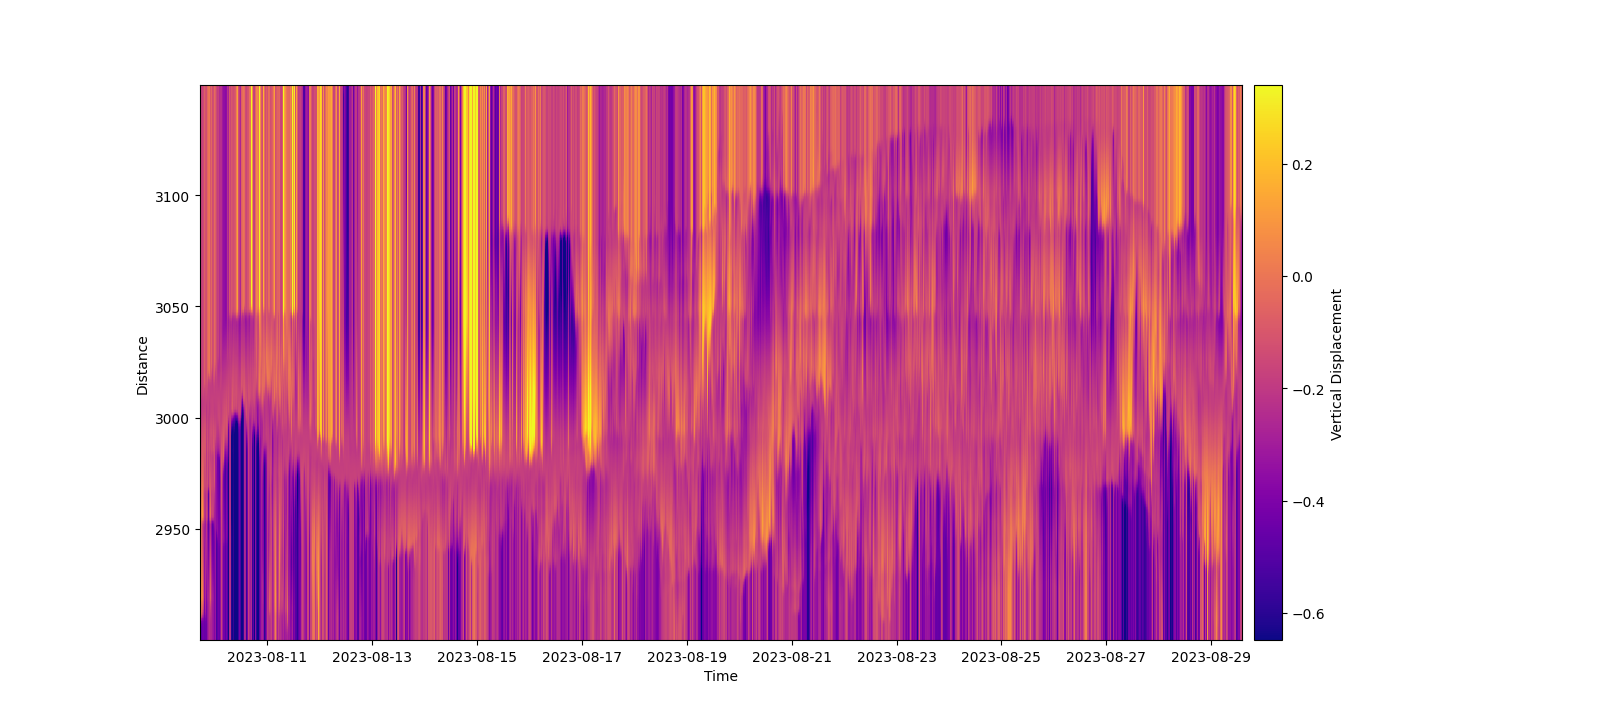

In [8]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
# for i in range(len(disps_interp[:, 0])): plt.plot(plot_times_zoomed, depths[i, :] + disps_interp[i, :])
ddt = np.gradient(disps_interp, axis=1)
im1 = ax.imshow(disps_interp, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(disps_interp[~np.isnan(disps_interp)],1),
            vmax=np.percentile(disps_interp[~np.isnan(disps_interp)],99),
            )
ax.set_ylabel('Distance') 
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Vertical Displacement')
plt.show()


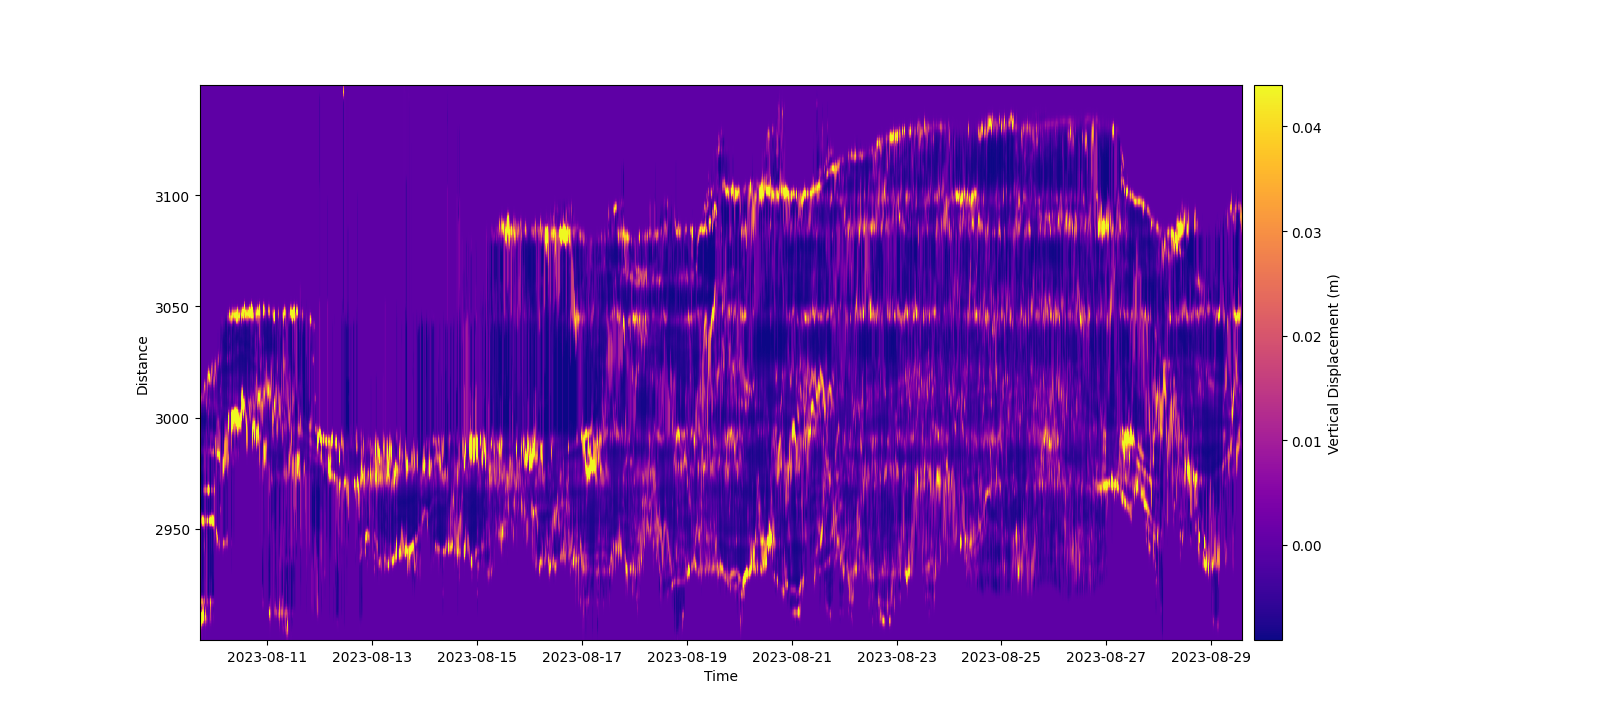

In [9]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
disps_interp = scipy.ndimage.gaussian_filter1d(disps_interp, 0.01) 
# for i in range(len(disps_interp[:, 0])): plt.plot(plot_times_zoomed, depths[i, :] + disps_interp[i, :])
ddt = np.gradient(disps_interp, axis=0)
ddtdt = np.gradient(ddt, axis=0)
im1 = ax.imshow(ddt, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(ddt[~np.isnan(ddt)],1),
            vmax=np.percentile(ddt[~np.isnan(ddt)],99),
            )
ax.set_ylabel('Distance') 
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Vertical Displacement (m)')
plt.show()


## Temperature plotted data

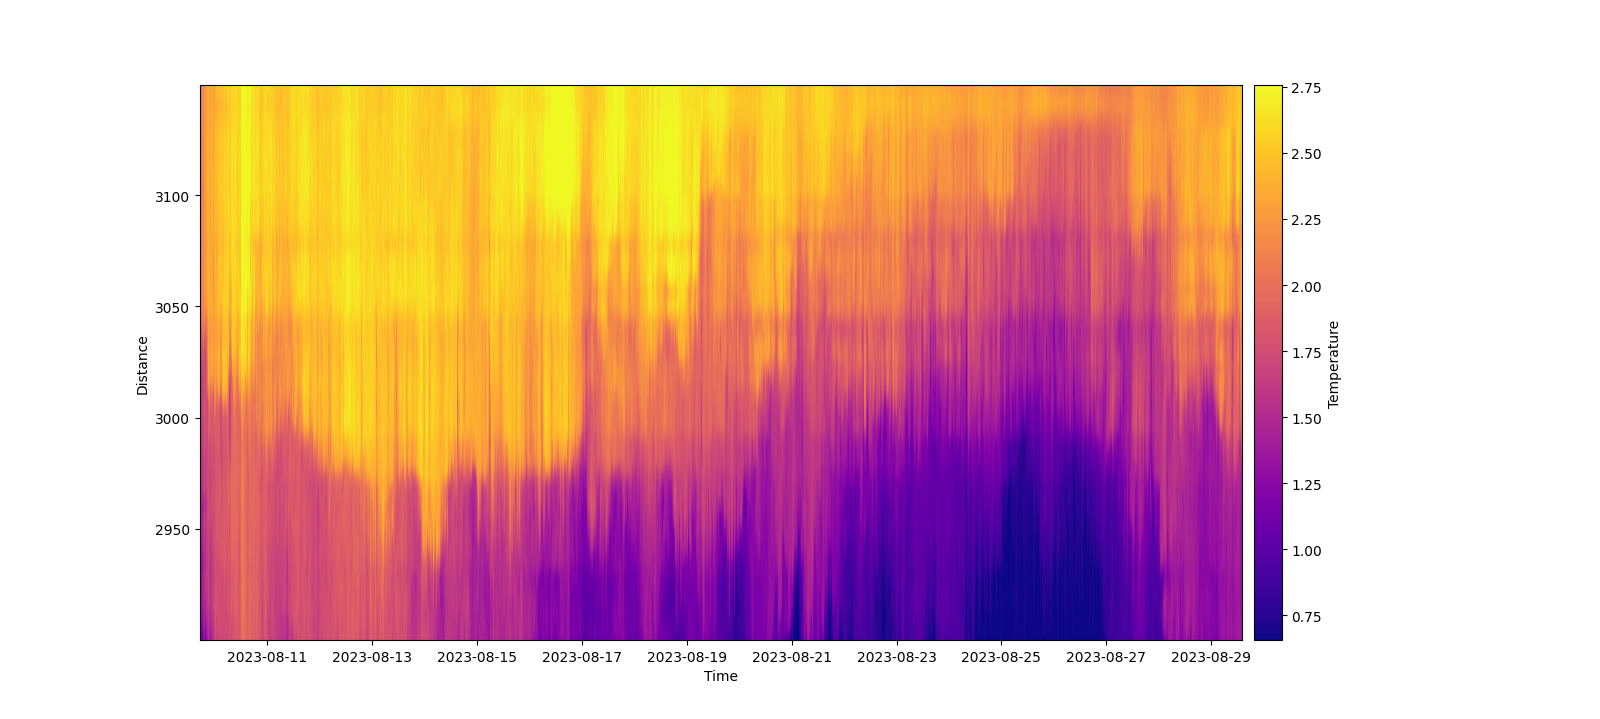

In [10]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
im1 = ax.imshow(filtered_arr.T, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(filtered_arr[~np.isnan(filtered_arr)],1),
            vmax=np.percentile(filtered_arr[~np.isnan(filtered_arr)],99),
            )
# for i in range(len(contour_values)): plt.plot(plot_times_zoomed, contour_points_arr[i], '-')
# for i in range(len(contour_values)): plt.plot(contour_points[contour_values[i]]['t'], contour_points[contour_values[i]]['x'], '.')
# plt.contour(plot_times_zoomed, plot_dists_zoomed, filtered_arr.T, contour_values)

ax.set_ylabel('Distance')
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Temperature')
plt.show()

# Set up SINDy

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps
# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

## Trying with weak method

In [12]:
import contextlib
import warnings  # Import warnings to suppress warnings

In [13]:
t = np.array(plot_times_zoomed_int - plot_times_zoomed_int[0]) * 1.666e-11 # grid_x[:, 0]
x = depths_interp[:] - depths_interp[0] # grid_y[0, :]
T, X = np.meshgrid(t, x)

In [14]:
def get_coefs_weak(x, t, displacements, sparsity):
    dt = t[1] - t[0]
    dx = x[1] - x[0]


    u_sol = displacements[:, :]

    u = np.zeros((len(x), len(t), 1))
    u[:, :, 0] = u_sol
    u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)

    ux = ps.FiniteDifference(d=1, axis=0)._differentiate(u, dx)
    uxx = ps.FiniteDifference(d=2, axis=0)._differentiate(u, dx)
    uxxx = ps.FiniteDifference(d=3, axis=0)._differentiate(u, dx)

    # Define PDE library that is quadratic in u, and 
    # third-order in spatial derivatives of u.
    spatiotemporal_grid=np.zeros((len(x),len(t),2))
    spatiotemporal_grid[:,:,0]=x[:,np.newaxis]
    spatiotemporal_grid[:,:,1]=t[np.newaxis,:]

    multiindices = np.array([
        [0, 0],
        [0, 1], # u
        [1, 0],
        [0, 2],
        [2, 0]
        # [1, 0],  # du/dx
        # [0, 1],  # du/dt
        # [2, 0],  # d^2u/dx^2
        # [0, 2],  # d^2u/dt^2
        # [1, 1]   # d^2u/dxdt
    ])
    
    weak_library = ps.PDELibrary(library_functions=[
            lambda u: u,
            lambda u: u**2
        ],
        function_names=[
            lambda u: 'u',
            lambda u: 'u^2'
        ], 
        derivative_order=2, spatial_grid=x, temporal_grid=t, 
        include_bias=True, is_uniform=True,implicit_terms=True, multiindices=multiindices)

    np.random.seed(1)

    sindy_opt = ps.SINDyPI(
        threshold=sparsity, max_iter=1000, tol=1e-10,
        thresholder='l1', normalize_columns=False
    )
    model = ps.SINDy(feature_library=weak_library, optimizer=sindy_opt, feature_names='u')
    with contextlib.redirect_stdout(None):
        model.fit(u, t=dt, quiet=True)
    coefficients = model.coefficients()
    coefficients = coefficients[4, :]
    feature_names = model.get_feature_names()
    try:
        lhs_actual=weak_library.transform(u)
        lhs_predict=model.predict(u)
        scores=[r2_score(np.reshape(lhs_actual[:,:,ind],(np.product(lhs_actual.shape[:-1]))),np.reshape(lhs_predict[:,:,ind],(np.product(lhs_actual.shape[:-1])))) for ind in range(lhs_predict.shape[-1])]
    except:
        scores = np.zeros(12)


    return feature_names, coefficients, scores[4]

In [15]:
# Run the weak model on n_segments number of different segements of window size window_size and step size step_size. This usually takes quite a while. 
# The get_coefs_weak function returns only the 4th coefficient, which is the u' = ... term

t = np.array(plot_times_zoomed_int - plot_times_zoomed_int[0]) * 1.666e-11 # grid_x[:, 0]
x = depths_interp - depths_interp[0] # grid_y[0, :]
window_size = 500
step_size = 500 # 20
n_segments = int(len(t)/step_size) - 1
feature_names, temp, score = get_coefs_weak(x, t[0:100], disps_interp[:, 0:100], 4e-2)
coefficients = np.empty((len(temp), n_segments))
segment_t = [0] * n_segments
sparsity = 2e-3
scores = np.empty(n_segments)

for i in tqdm(range(n_segments)):
    start_t_ind = i*step_size# int(i * (len(t)/(n_segments)))
    end_t_ind = i*step_size + window_size # int((i+1) * (len(t)/(n_segments)))
    if(end_t_ind > len(t) - 1): end_t_ind = len(t) - 1
    segment_t[i] = plot_times_zoomed[int((start_t_ind + end_t_ind)/2)]
    feature_names, coefficients[:, i], score = get_coefs_weak(x, t[start_t_ind:end_t_ind], disps_interp[:, start_t_ind:end_t_ind], sparsity)
    coefficients[:, i] = np.array(coefficients[:, i])
    scores[i] = score

/var/folders/0w/3nhprhs523j29wbz2w1cnrl00000gn/T/ipykernel_50321/2818981338.py:9: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  feature_names, temp, score = get_coefs_weak(x, t[0:100], disps_interp[:, 0:100], 4e-2)
  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/0w/3nhprhs523j29wbz2w1cnrl00000gn/T/ipykernel_50321/2818981338.py:20: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  feature_names, coefficients[:, i], score = get_coefs_weak(x, t[start_t_ind:end_t_ind], disps_interp[:, start_t_ind:end_t_ind], sparsity)
 10%|█         | 1/10 [00:50<07:30, 50.00s/it]/var/folders/0w/3nhprhs523j29wbz2w1cnrl00000gn/T/ipykernel_50321/2818981338.py:20: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  feature_names, coefficients[:, i], score = get_coefs_weak(x, t[

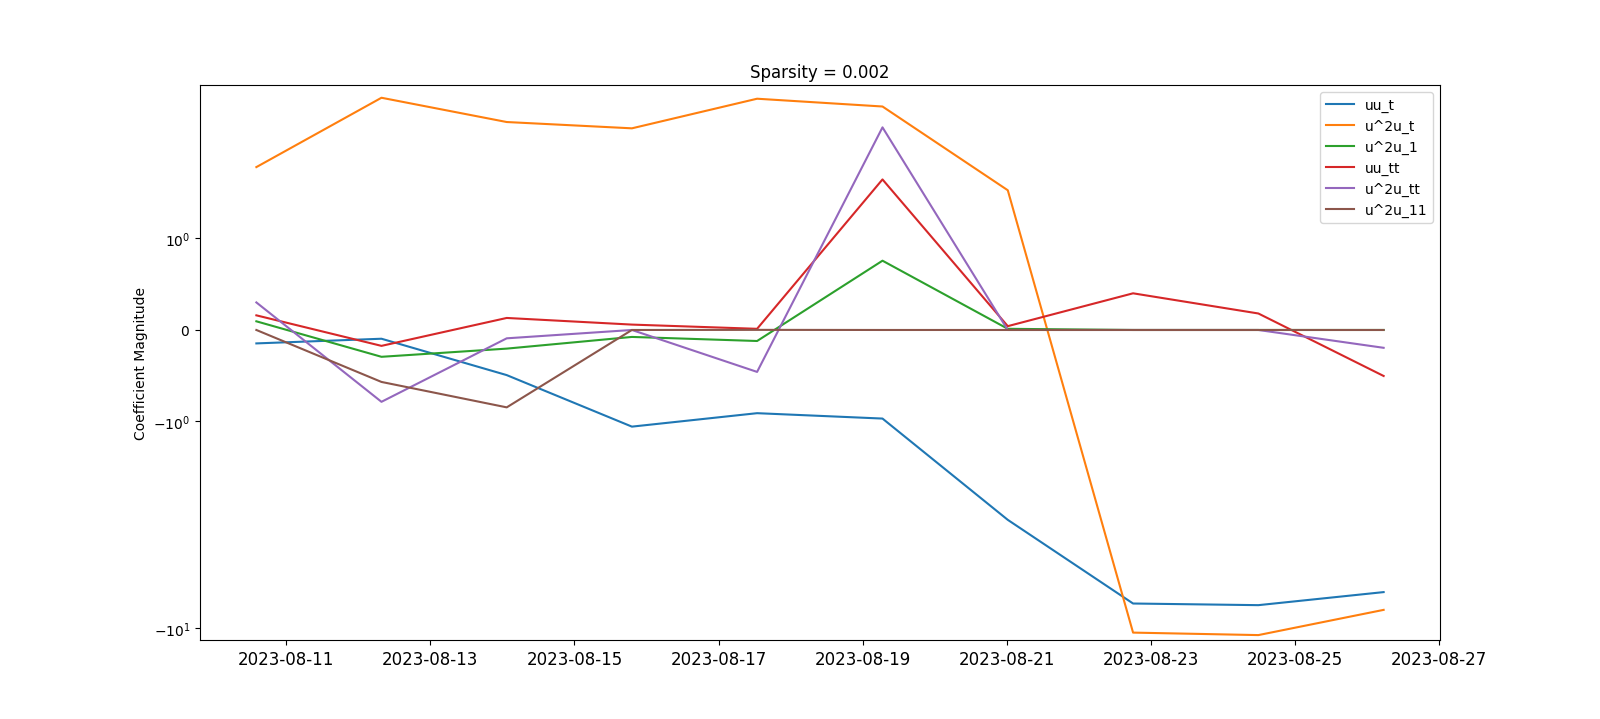

In [19]:
# Plot the coefficients over time
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
for i in range(len(feature_names)): 
    if(np.average(np.abs(coefficients[i, :])) > 1e-1): plt.plot(segment_t, scipy.ndimage.gaussian_filter1d(coefficients[i, :], 0.01), '-', label=feature_names[i])

plt.title("Sparsity = " + str(sparsity))
plt.xticks(fontsize=12)
plt.yscale('symlog')
plt.ylabel('Coefficient Magnitude')
plt.legend()

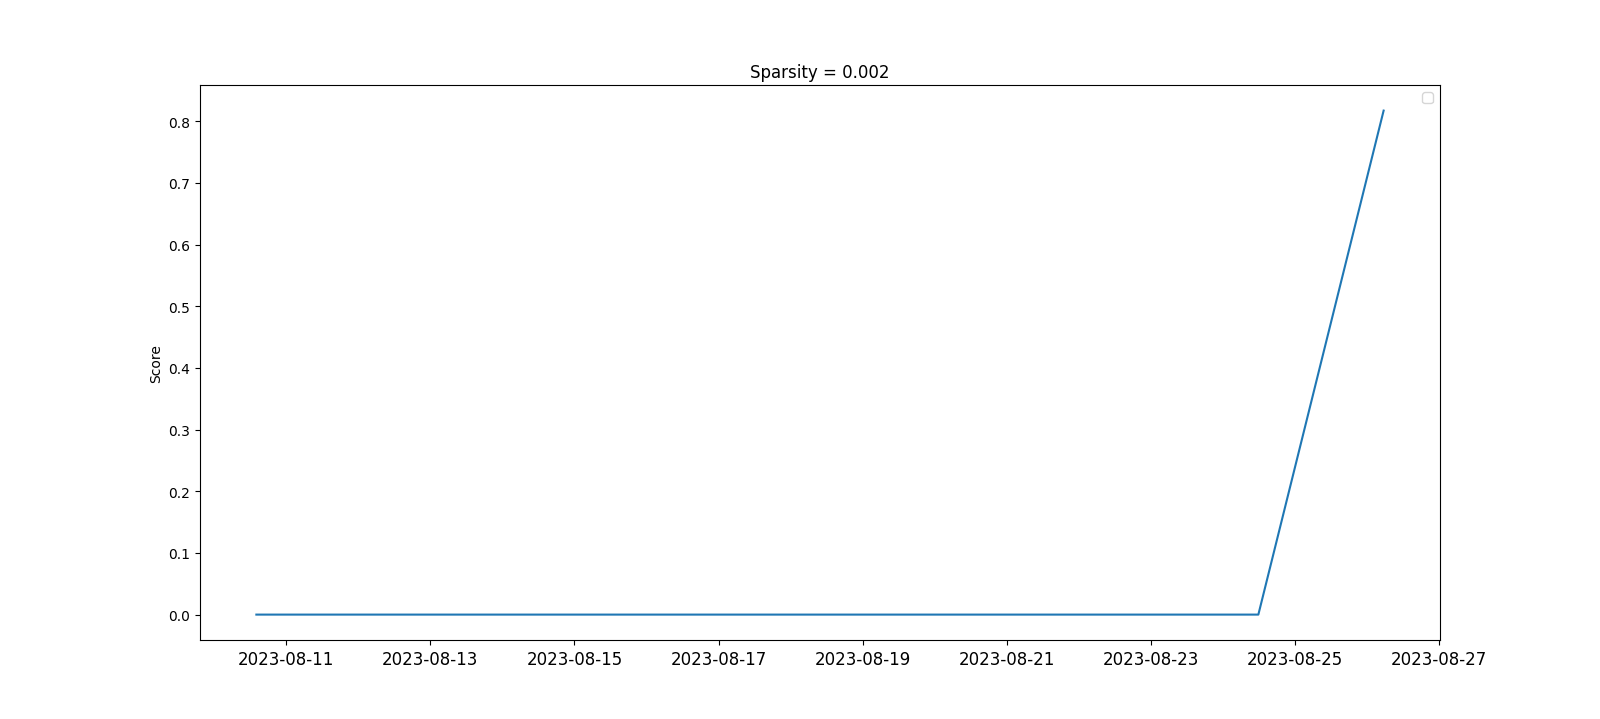

In [22]:
# Score vs. time plot
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
plt.plot(segment_t, scores)
plt.title("Sparsity = " + str(sparsity))
plt.xticks(fontsize=12)
plt.ylabel("Score")
plt.legend()

## One run of the weak formulation
This part just runs the weak SINDy on the entire dataset. Doesn't produce any helpful results but is useful for running on smaller segments

In [25]:
train_ind = -1
t = np.array(plot_times_zoomed_int - plot_times_zoomed_int[0]) * 1.666e-11 # grid_x[:, 0]
x = depths_interp[:] - depths_interp[0] # grid_y[0, :]
dt = t[1] - t[0]
dx = x[1] - x[0]

u_sol = disps_interp


u = np.zeros((len(x), len(t), 1))
u[:, :, 0] = u_sol
u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)

ux = ps.FiniteDifference(d=1, axis=0)._differentiate(u, dx)
uxx = ps.FiniteDifference(d=2, axis=0)._differentiate(u, dx)
uxxx = ps.FiniteDifference(d=3, axis=0)._differentiate(u, dx)


In [46]:
# Define PDE library that is quadratic in u, and 
# third-order in spatial derivatives of u for curiosity
spatiotemporal_grid=np.zeros((len(x),len(t),2))
spatiotemporal_grid[:,:,0]=x[:,np.newaxis]
spatiotemporal_grid[:,:,1]=t[np.newaxis,:]

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
np.random.seed(1)

In [27]:
multiindices=np.array([[0,1],[0,2],[1,0],[2,0]])
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=2, spatial_grid=x, temporal_grid=t,
                        include_bias=True, is_uniform=True,implicit_terms=True, multiindices=multiindices)

sindy_opt = ps.SINDyPI(
    threshold=1e-1, max_iter=1000, tol=1e-10,
    thresholder='l1', normalize_columns=False
)
model = ps.SINDy(feature_library=pde_lib, optimizer=sindy_opt)
model.fit(u, t=dt)
model.print()
# print('score', model.score(u,t=dt))

Model  0


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 0, try changing your library
  warnings.warn(


Model  1


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 1, try changing your library
  warnings.warn(


Model  2


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 2, try changing your library
  warnings.warn(


Model  3
Model  4
Model  5
Model  6
Solver failed on model  6 , setting coefs to zeros
Model  7
Model  8
Model  9
Model  10
Model  11
Model  12
Model  13
Model  14
1 = nan 1 + nan x0 + nan x0x0 + nan x0_t + nan x0_tt + nan x0_1 + nan x0_11 + nan x0x0_t + nan x0x0x0_t + nan x0x0_tt + nan x0x0x0_tt + nan x0x0_1 + nan x0x0x0_1 + nan x0x0_11 + nan x0x0x0_11
x0 = nan 1 + nan x0 + nan x0x0 + nan x0_t + nan x0_tt + nan x0_1 + nan x0_11 + nan x0x0_t + nan x0x0x0_t + nan x0x0_tt + nan x0x0x0_tt + nan x0x0_1 + nan x0x0x0_1 + nan x0x0_11 + nan x0x0x0_11
x0x0 = nan 1 + nan x0 + nan x0x0 + nan x0_t + nan x0_tt + nan x0_1 + nan x0_11 + nan x0x0_t + nan x0x0x0_t + nan x0x0_tt + nan x0x0x0_tt + nan x0x0_1 + nan x0x0x0_1 + nan x0x0_11 + nan x0x0x0_11
x0_t = 0.001 x0x0 + -0.010 x0_tt + -0.011 x0_1 + -0.603 x0x0_t + 2.262 x0x0x0_t + 0.049 x0x0_tt + -0.099 x0x0x0_tt + -0.020 x0x0_1
x0_tt = -0.001 1 + -0.009 x0 + -0.016 x0x0 + -0.002 x0_t + -0.007 x0_1 + 0.074 x0_11 + 0.012 x0x0_t + -0.003 x0x0x0_t + -0.82

In [45]:
# Create list of scores for each model

lhs_actual=pde_lib.transform(u)
lhs_predict=model.predict(u)
scores = [] 
for ind in range(lhs_predict.shape[-1]):
    try: scores.append(r2_score(np.reshape(lhs_actual[:,:,ind],(np.product(lhs_actual.shape[:-1]))),np.reshape(lhs_predict[:,:,ind],(np.product(lhs_actual.shape[:-1])))))
    except: scores.append(0)

order=np.argsort(scores)
for ind in np.flip(order[-5:]):
    print(pde_lib.get_feature_names()[ind] + '=' + model.equations()[ind] + ', score=' +str(scores[ind]))

x0x0_1=-0.003 x0_tt + -0.101 x0_1 + -0.156 x0_11 + -1.118 x0x0x0_1 + -0.935 x0x0_11 + -1.392 x0x0x0_11, score=0.7085242850471527
x0x0x0_1=0.021 x0_1 + -0.062 x0_11 + -0.232 x0x0_1 + -0.454 x0x0_11, score=0.6606966189288417
x0x0_11=-0.001 x0x0 + -0.015 x0_1 + -0.135 x0_11 + -0.139 x0x0_1 + -0.411 x0x0x0_1 + -0.330 x0x0x0_11, score=0.6268330560641471
x0_1=-0.002 x0x0 + -0.004 x0_t + -0.017 x0_tt + -0.473 x0_11 + -0.002 x0x0_t + 0.001 x0x0x0_t + -0.005 x0x0_tt + 0.015 x0x0x0_tt + -2.292 x0x0_1 + 1.225 x0x0x0_1 + -2.331 x0x0_11 + -4.348 x0x0x0_11, score=0.5081765925412518
x0x0x0_11=-0.008 x0_1 + 0.042 x0_11 + -0.070 x0x0_1 + -0.112 x0x0_11, score=0.5066325671569967


<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
/var/folders/0w/3nhprhs523j29wbz2w1cnrl00000gn/T/ipykernel_50321/323179050.py:13: SyntaxWarning: invalid escape sequence '\d'
  plt.title('Ground truth $\dot{u}$')
/var/folders/0w/3nhprhs523j29wbz2w1cnrl00000gn/T/ipykernel_50321/323179050.py:25: SyntaxWarning: invalid escape sequence '\d'
  plt.title('Fitted $\dot{u}$')


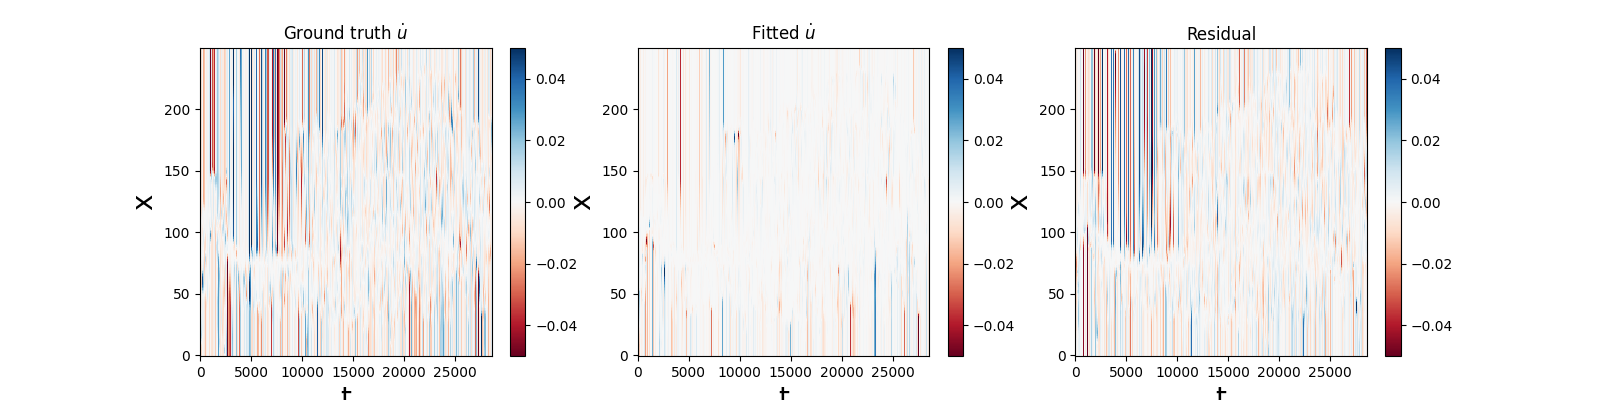

In [47]:
u_dot_pred = model.predict(u)
model_num = 3
min = -5e-2
max = 5e-2
# Make fancy plot comparing derivative
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
# plt.pcolormesh(t_test, x, u_dot_test, vmin=-1.5, vmax=1.5)
plt.pcolormesh(t, x, u_dot[:, :, 0], shading='nearest', vmin=min, vmax=max, cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Ground truth $\dot{u}$')
ax = plt.gca()


plt.subplot(1, 3, 2)
# u_dot_stlsq = np.reshape(u_dot_stlsq, (len(x), len(t_test)))
# plt.pcolormesh(t_test, x, u_dot_stlsq, vmin=-1.5, vmax=1.5)
# u_dot_stlsq = np.reshape(u_dot_sr3, (len(x), len(t_test), 1))
plt.pcolormesh(t, x, u_dot_pred[:,:,model_num], shading='nearest', vmin=min, vmax=max, cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Fitted $\dot{u}$')
ax = plt.gca()

plt.subplot(1, 3, 3)
# plt.pcolormesh(t_test, x, u_dot_stlsq - u_dot_test, vmin=-1.5, vmax=1.5)
plt.pcolormesh(t, x, u_dot_pred[:,:,model_num] - u_dot[:,:,0], vmin=min, vmax=max, cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Residual')
ax = plt.gca()

plt.show()